# Исследование надёжности заёмщиков

Заказчик — кредитный отдел банка. Нужно разобраться, влияет ли семейное положение и количество детей клиента на факт погашения кредита в срок. Входные данные от банка — статистика о платёжеспособности клиентов.

Результаты исследования будут учтены при построении модели **кредитного скоринга** — специальной системы, которая оценивает способность потенциального заёмщика вернуть кредит банку.

## Общая информация

In [2]:
import pandas as pd
data = pd.read_csv('/datasets/data.csv')

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21525 entries, 0 to 21524
Data columns (total 12 columns):
children            21525 non-null int64
days_employed       19351 non-null float64
dob_years           21525 non-null int64
education           21525 non-null object
education_id        21525 non-null int64
family_status       21525 non-null object
family_status_id    21525 non-null int64
gender              21525 non-null object
income_type         21525 non-null object
debt                21525 non-null int64
total_income        19351 non-null float64
purpose             21525 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 2.0+ MB


In [4]:
data.head(5)

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
0,1,-8437.673028,42,высшее,0,женат / замужем,0,F,сотрудник,0,253875.639453,покупка жилья
1,1,-4024.803754,36,среднее,1,женат / замужем,0,F,сотрудник,0,112080.014102,приобретение автомобиля
2,0,-5623.422610,33,Среднее,1,женат / замужем,0,M,сотрудник,0,145885.952297,покупка жилья
3,3,-4124.747207,32,среднее,1,женат / замужем,0,M,сотрудник,0,267628.550329,дополнительное образование
4,0,340266.072047,53,среднее,1,гражданский брак,1,F,пенсионер,0,158616.077870,сыграть свадьбу


**Вывод**

 - В датафрейме 21525 строк
 - В столбцах days_employed, total_income есть пропуски. Причем одинаковое количество в обоих столбцах
 - По первым пяти строчкам видно, что в столбце days_employed есть как положительные, так и отрицательные значения

**Проверим пропуски (пока просто, до обработки). Сначала почистим данные, потом будем восстанавливать**

In [5]:
data_len_raw = data.shape[0]

In [6]:
data.isna().sum()

children               0
days_employed       2174
dob_years              0
education              0
education_id           0
family_status          0
family_status_id       0
gender                 0
income_type            0
debt                   0
total_income        2174
purpose                0
dtype: int64

In [7]:
print(f"Объединение количества пропусков в столбцах days_employed и total_income: {data.loc[data['days_employed'].isna() | data['days_employed'].isna()].shape[0]}")
print(f"Пересечение количества пропусков в столбцах days_employed и total_income: {data.loc[data['days_employed'].isna() & data['days_employed'].isna()].shape[0]}")

Объединение количества пропусков в столбцах days_employed и total_income: 2174
Пересечение количества пропусков в столбцах days_employed и total_income: 2174


- В 10% случаев мы видим пропуски в данных. Пропуски в данных наблюдаются одновременно в двух столбцах: трудовой стаж и зарплата, что похоже на системную ошибку. Возможно при выгрузке данных происходит сбой. Возможно, или эти поля можно не заполнять, если клитент зарплатный
- Процент пропусков достаточно велик, чтобы полностью исключать эти строки их анализа. Исключение строк может исказить общую картину. Поэтому, будем восстанавливать данные

## Исследование данных

### Сначала изучим данные на выбросы прежде, чем восполнять пропуски

#### **children - количество детей**

In [8]:
data['children'].value_counts()

 0     14149
 1      4818
 2      2055
 3       330
 20       76
-1        47
 4        41
 5         9
Name: children, dtype: int64

- Отрицательное количество детей - это странно, эти значения не можем считать валидными
- Число 20 - тоже необычное. Чисто теоретически, такое возможно. но в данных мы видим значения от 0 до 5, и сразу 20. Будем считать это выбросом
- Т.к. мы изучаем двияние от количества детей, не валидные значения нам не подходят. Удаляем такие записи

In [9]:
data = data.query("children>=0 and children!=20")
data['children'].value_counts()

0    14149
1     4818
2     2055
3      330
4       41
5        9
Name: children, dtype: int64


#### **days_employed: общий трудовой стаж в днях**

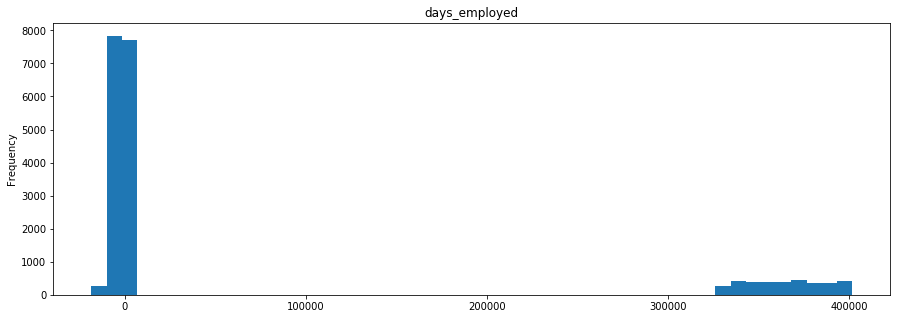

In [10]:
data['days_employed'].plot(kind='hist', title='days_employed', bins=50, figsize=(15,5))

In [12]:
data.query("days_employed>=0").shape[0]

3431

Видим странную картину: 
- большая часть значений меньше нуля. Можно предположить, что это количество считается от текущего дня в обратную сторону. Домножим на -1.
- есть значения, корые намного больше нуля: около 300-400тыс. Нужно выяснить у владельца данных, откуда такие значения. Сецчас у нас такой возможности нет. Затираем эти значения как не валидные (сами строчки отставяем)

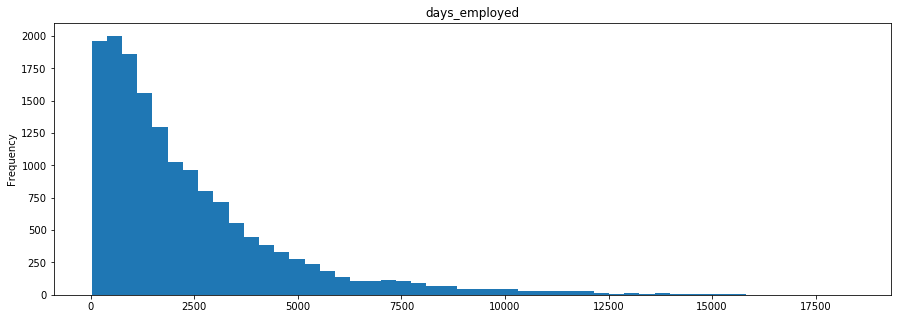

In [13]:
data['days_employed']= data['days_employed'][data['days_employed'] <= 0]
data['days_employed'] = data['days_employed']*(-1)
data['days_employed'].plot(kind='hist', title='days_employed', bins=50, figsize=(15,5))

#### **dob_years - возраст клиента в годах**

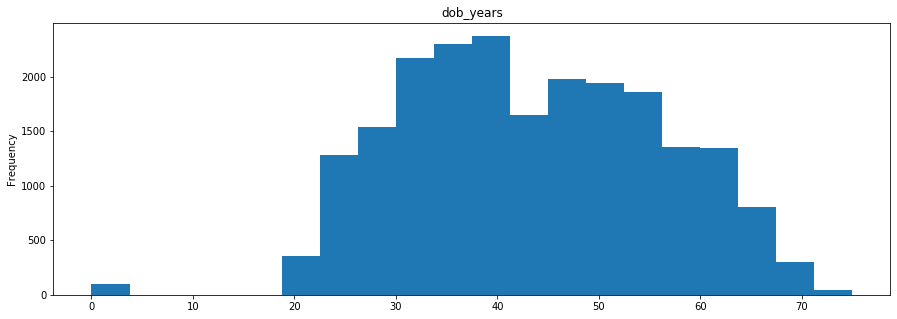

In [14]:
data['dob_years'].plot(kind='hist', title='dob_years', bins=20, figsize=(15,5))

 - Слишком маленький возраст не позволяет брать кредит. Данные, имеющие значение меньше 18 лет считаем не валидными
 - Таких значений не много, пренебрежем ими, удалив полностью строки

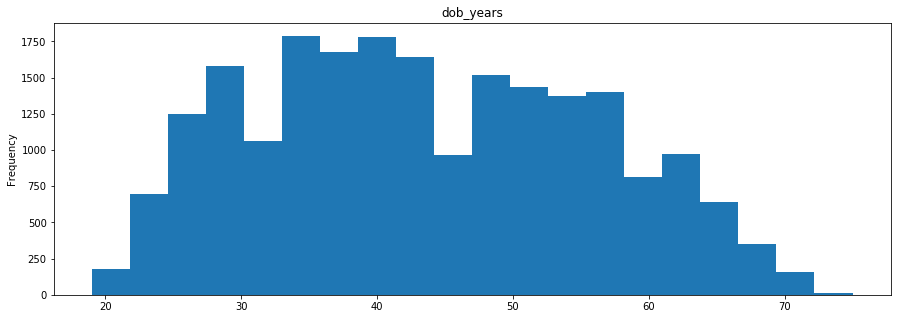

In [15]:
data = data.query("dob_years>=18")
data['dob_years'].plot(kind='hist', title='dob_years', bins=20, figsize=(15,5))

#### **education - Образование**

In [16]:
data['education'].value_counts()

среднее                13609
высшее                  4666
СРЕДНЕЕ                  764
Среднее                  700
неоконченное высшее      663
ВЫСШЕЕ                   270
Высшее                   266
начальное                250
Неоконченное высшее       47
НЕОКОНЧЕННОЕ ВЫСШЕЕ       29
НАЧАЛЬНОЕ                 17
Начальное                 15
ученая степень             4
Ученая степень             1
УЧЕНАЯ СТЕПЕНЬ             1
Name: education, dtype: int64

In [17]:
#Приведем в нижний регистр
data['education'] = data['education'].str.lower()
data['education'].value_counts()

среднее                15073
высшее                  5202
неоконченное высшее      739
начальное                282
ученая степень             6
Name: education, dtype: int64

#### **education_id - идентификатор уровня образования**

In [18]:
data.groupby(['education', 'education_id'])['education'].count()

education            education_id
высшее               0                5202
начальное            3                 282
неоконченное высшее  2                 739
среднее              1               15073
ученая степень       4                   6
Name: education, dtype: int64

#### **family_status — семейное положение**

In [19]:
data['family_status'].value_counts()

женат / замужем          12254
гражданский брак          4139
Не женат / не замужем     2783
в разводе                 1179
вдовец / вдова             947
Name: family_status, dtype: int64

#### **family_status_id — идентификатор семейного положения**

In [20]:
data.groupby(['family_status', 'family_status_id'])['education'].count()

family_status          family_status_id
Не женат / не замужем  4                    2783
в разводе              3                    1179
вдовец / вдова         2                     947
гражданский брак       1                    4139
женат / замужем        0                   12254
Name: education, dtype: int64

#### **gender — пол клиента**

In [21]:
data['gender'].value_counts()

F      14083
M       7218
XNA        1
Name: gender, dtype: int64

XNA - это нет данных, видимо. Оставим

#### **income_type — тип занятости**

In [22]:
data['income_type'].value_counts()

сотрудник          10996
компаньон           5034
пенсионер           3819
госслужащий         1447
предприниматель        2
безработный            2
в декрете              1
студент                1
Name: income_type, dtype: int64

#### **debt — имел ли задолженность по возврату кредитов**

In [23]:
data['debt'].value_counts()

0    19578
1     1724
Name: debt, dtype: int64

#### **total_income — ежемесячный доход**

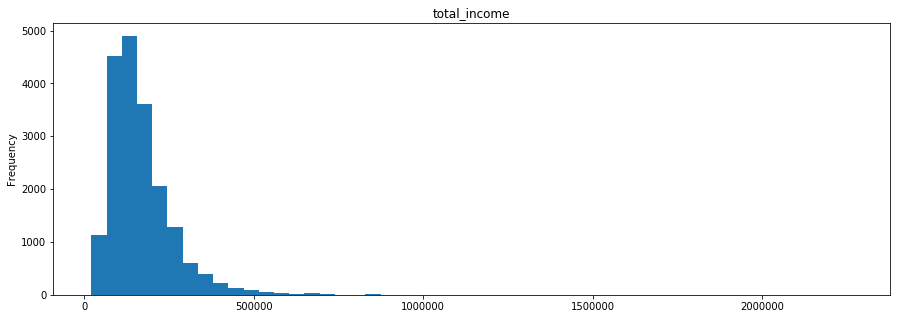

In [24]:
data['total_income'].plot(kind='hist', title='total_income', bins=50, figsize=(15,5))

**ок**

#### **purpose — цель получения кредита**

In [25]:
data['purpose'].value_counts()

свадьба                                   791
на проведение свадьбы                     768
сыграть свадьбу                           764
операции с недвижимостью                  670
покупка коммерческой недвижимости         658
покупка жилья для сдачи                   649
операции с коммерческой недвижимостью     644
операции с жильем                         642
покупка жилья для семьи                   639
жилье                                     636
покупка жилья                             635
недвижимость                              628
операции со своей недвижимостью           626
строительство собственной недвижимости    626
строительство недвижимости                620
строительство жилой недвижимости          619
покупка своего жилья                      618
покупка недвижимости                      616
ремонт жилью                              607
покупка жилой недвижимости                600
на покупку своего автомобиля              501
заняться высшим образованием      

**Это пока оставим. Выглядит нормально**

**Посмотрим, сколько данных осталось**

In [26]:
print (f"Было данных до чистки: {data_len_raw}")
print (f"Стало данных после чистки: {data.shape[0]}")
print (f"Процент удаленных данных данных: {(data_len_raw - data.shape[0]) / data_len_raw * 100: .2f}")

Было данных до чистки: 21525
Стало данных после чистки: 21302
Процент удаленных данных данных:  1.04


### Обработка пропусков

In [27]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21302 entries, 0 to 21524
Data columns (total 12 columns):
children            21302 non-null int64
days_employed       15736 non-null float64
dob_years           21302 non-null int64
education           21302 non-null object
education_id        21302 non-null int64
family_status       21302 non-null object
family_status_id    21302 non-null int64
gender              21302 non-null object
income_type         21302 non-null object
debt                21302 non-null int64
total_income        19150 non-null float64
purpose             21302 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 2.1+ MB


#### **Изучение пропусков**

In [29]:
data.isna().sum()

children               0
days_employed       5566
dob_years              0
education              0
education_id           0
family_status          0
family_status_id       0
gender                 0
income_type            0
debt                   0
total_income        2152
purpose                0
dtype: int64

In [30]:
print("Объединение количества пропусков в столбцах days_employed и total_income:", data.query("days_employed.isna() or total_income.isna()").shape[0])
print("Пересечение количества пропусков в столбцах days_employed и total_income:", data.query("days_employed.isna() and total_income.isna()").shape[0])

Объединение количества пропусков в столбцах days_employed и total_income: 5566
Пересечение количества пропусков в столбцах days_employed и total_income: 2152


#### **Группировка возраста для даленьйшего восстановления пропусков по этой переменной**

- Нам нужно восстановить данные в двух столбцах: days_employed(общий трудовой стаж в днях) и total_income(ежемесячный доход)
- Данные будем восстанавливать не из расчета "среднее по больнице". Будем смотреть на возрастной интервал и образование. Пол брать не будем, т.к.верим, что это тут не при чем =)
- сгруппируем возраст в возрастные интервалы для дальнейшего восстановления пропущенных значений 

In [31]:
def age_group(age):
    #сгруппируем возраст в возрастные интервалы
    if age >= 18 and age <= 25:
        return '1. 18-25'
    if age >= 26 and age <= 35:
        return '2. 26-35'
    if age >= 36 and age <= 45:
        return '3. 36-45'
    if age >= 46 and age <= 55:
        return '4. 46-55'
    if age >= 55:
        return '5. Выше 55'
    
data['dob_years_group'] = data['dob_years'].apply(age_group)
print(data['dob_years_group'].value_counts())

3. 36-45      5596
2. 26-35      5326
4. 46-55      4802
5. Выше 55    4349
1. 18-25      1229
Name: dob_years_group, dtype: int64


#### **Заполнение пропусков**

 **заполним пропуски**
- циклом проходимся по каждой группе DataFrame и заполсяем пропущенные значения соответствующей статистикой
- пропуски заполняем по принципу:
  - переменную days_employed заполняем средним значением этой переменной в соответствующей группе
  - переменную total_income заполняем медианным значением этой переменной в соответствующей группе. Медиану взял для того, чтобы исключить сильное влияние очень богатых людей

In [33]:
#### заполняем пропуски

emptydata = data[0:0] 
#проходимся цикром по уникальным значениям переменных education и dob_years_group
for education in data['education'].unique():
    for year in data['dob_years_group'].unique():
        
        #currdata - это часть DataFrame data, отфильтрованная по двум переменным (year, education)
        currdata = data.query(f"dob_years_group == '{year}' and education=='{education}'")
        curr_mean_employed = data.query(f"dob_years_group == '{year}' and education=='{education}'")['days_employed'].mean()
        curr_median_income = data.query(f"dob_years_group == '{year}' and education=='{education}'")['total_income'].median()

        #восполняем пропуски
        currdata.loc[currdata['days_employed'].isna(), 'days_employed'] = curr_mean_employed
        currdata.loc[currdata['total_income'].isna(), 'total_income'] = curr_median_income
        
        #объединяем курси в общий DataFrame
        emptydata = emptydata.append(currdata)
data = emptydata

In [34]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21302 entries, 0 to 12786
Data columns (total 13 columns):
children            21302 non-null int64
days_employed       21302 non-null float64
dob_years           21302 non-null int64
education           21302 non-null object
education_id        21302 non-null int64
family_status       21302 non-null object
family_status_id    21302 non-null int64
gender              21302 non-null object
income_type         21302 non-null object
debt                21302 non-null int64
total_income        21302 non-null float64
purpose             21302 non-null object
dob_years_group     21302 non-null object
dtypes: float64(2), int64(5), object(6)
memory usage: 2.3+ MB


**Вывод**

Были обнаружены пропуски в двух столбцах:
 - days_employed
 - total_income
 
В переменной days_employed так же были не валидные значения, которые мы исключили перед тем, как восстанавливать данные

### Замена типа данных

In [35]:
data['days_employed'] = data['days_employed'].astype(int) 
data['total_income'] = data['total_income'].astype(int) 
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21302 entries, 0 to 12786
Data columns (total 13 columns):
children            21302 non-null int64
days_employed       21302 non-null int64
dob_years           21302 non-null int64
education           21302 non-null object
education_id        21302 non-null int64
family_status       21302 non-null object
family_status_id    21302 non-null int64
gender              21302 non-null object
income_type         21302 non-null object
debt                21302 non-null int64
total_income        21302 non-null int64
purpose             21302 non-null object
dob_years_group     21302 non-null object
dtypes: int64(7), object(6)
memory usage: 2.3+ MB


**Вывод**

Т.к. нужен перевод в целое число, используем метод astype, который позводит это сделать

### Обработка дубликатов

In [36]:
print (f"Количество дубликатов до удаления: ", data.duplicated().sum())
data = data.drop_duplicates().reset_index(drop = True)
print (f"Количество дубликатов после удаления: ", data.duplicated().sum())

Количество дубликатов до удаления:  71
Количество дубликатов после удаления:  0


**Вывод**

- Дубликаты в переменной education, связанные с регистром значений, мы убрали в рамках чистки данных
- Полные дубликаты убрали методом drop_duplicates

### Лемматизация

In [37]:
data.head(5)

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose,dob_years_group
0,1,8437,42,высшее,0,женат / замужем,0,F,сотрудник,0,253875,покупка жилья,3. 36-45
1,0,2879,43,высшее,0,женат / замужем,0,F,компаньон,0,240525,операции с жильем,3. 36-45
2,2,4171,36,высшее,0,женат / замужем,0,M,компаньон,0,113943,покупка недвижимости,3. 36-45
3,0,6448,43,высшее,0,гражданский брак,1,F,компаньон,0,154128,приобретение автомобиля,3. 36-45
4,0,335,36,высшее,0,женат / замужем,0,M,сотрудник,0,414404,недвижимость,3. 36-45


#### Добавим новый столбец, содержащий спиоск слов в именительном падеже из значения в столбце purpose

In [38]:
from pymystem3 import Mystem
from collections import Counter
m = Mystem() 

In [39]:
def lemma(text):
    lemmas = m.lemmatize(text)
    return lemmas

data['purpose_list'] = data['purpose'].apply(lemma)

In [40]:
data[['purpose', 'purpose_list']].head(5)

,purpose,purpose_list
0,покупка жилья,"[покупка, , жилье, \n]"
1,операции с жильем,"[операция, , с, , жилье, \n]"
2,покупка недвижимости,"[покупка, , недвижимость, \n]"
3,приобретение автомобиля,"[приобретение, , автомобиль, \n]"
4,недвижимость,"[недвижимость, \n]"


#### Сделаем частотку слов, которые встречаются в столбце lemma_list для дальнейшей группировки

In [41]:
from pandas.core.common import flatten

In [42]:
purpose_list = data['purpose_list'].to_list()
purpose_list = list(flatten(purpose_list))
pd.Series(purpose_list).value_counts()

                  33245
\n                21231
недвижимость       6291
покупка            5839
жилье              4413
автомобиль         4258
образование        3970
с                  2886
операция           2576
свадьба            2299
свой               2212
на                 2196
строительство      1862
высокий            1359
получение          1304
коммерческий       1298
для                1283
жилой              1216
сделка              933
заниматься          900
дополнительный      895
проведение          759
сыграть             755
сдача               647
семья               636
собственный         626
со                  623
ремонт              602
подержанный         479
подержать           471
приобретение        457
профильный          431
dtype: int64

In [186]:
len(pd.Series(purpose_list).value_counts())

32

**Вывод**

Мы выделили леммы значений столбца purpose. Для этого:
 - добавили столбец lemma_list в DataDrame,  который содержит список из значения столбца purpose.
   на основе этого столбца в дальнейшем будем проводить категоризацию целей кредита
 - построили частотное распределение слов, встречающихся в новом столбце lemma_list
 - видим 32 встречающихся слова. Кроме нужных, среди них пробелы, предлоги, и другое.
 - мы видим такие категории:
        '1. покупка недвижимости / жилья'
        '2. строительство недвижимости / жилья'
        '3. автомобиль'
        '4. образование'
        '5. ремонт'
        '6. свадьба'
        '7. операция'
        '8. жилье (без уточнения)'
        '9. недвижимость (без уточнения)'

### Категоризация данных

#### purpose - цель получения кредита

In [43]:
def purpose_group(col):
    #сгруппируем возраст в возрастные интервалы
    if 'недвижимость' in col and 'покупка' in col:
        return '1. покупка недвижимости / жилья'
    if 'жилье' in col and 'покупка' in col:
        return '1. покупка недвижимости / жилья'
    if 'недвижимость' in col and 'строительство' in col:
        return '2. строительство недвижимости / жилья'
    if 'жилье' in col and 'строительство' in col:
        return '2. строительство недвижимости / жилья'
    if 'автомобиль' in col:
        return '3. автомобиль'
    if 'образование' in col:
        return '4. образование'
    if 'ремонт' in col:
        return '5. ремонт'
    if 'свадьба' in col:
        return '6. свадьба'
    if 'операция' in col:
        return '7. операция'
    if 'жилье' in col:
        return '8. жилье (без уточнения)'
    if 'недвижимость' in col:
        return '9. недвижимость (без уточнения)'
    
data['purpose_group'] = data['purpose_list'].apply(purpose_group)

In [44]:
data.query('purpose_group.isnull()').shape[0]

0

In [45]:
data['purpose_group'].value_counts()

1. покупка недвижимости / жилья          4402
3. автомобиль                            4258
4. образование                           3970
7. операция                              2576
6. свадьба                               2299
2. строительство недвижимости / жилья    1862
8. жилье (без уточнения)                  635
9. недвижимость (без уточнения)           627
5. ремонт                                 602
Name: purpose_group, dtype: int64

#### total_income -  ежемесячный доход

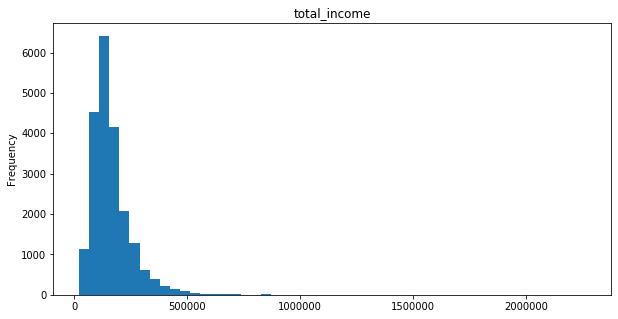

In [46]:
data['total_income'].plot(kind='hist', title='total_income', bins=50, figsize=(10,5))

In [47]:
def income_group(col):
    if col<30000:
        return '1. Менее 30000'
    if col>=30000 and col<50000:
        return '2. 30000 - 50000'
    if col>=50000 and col<80000:
        return '3. 50000 - 80000'
    if col>=80000 and col<120000:
        return '4. 80000 - 120000'
    if col>=120000 and col<160000:
        return '5. 120000 - 160000'
    if col>=160000 and col<200000:
        return '6. 160000 - 200000'
    if col>=200000 and col<300000:
        return '7. 200000 - 300000'
    if col>=300000 and col<500000:
        return '8. 300000 - 500000'
    if col>500000:
        return '9. Более 500000'
    
data['total_income_group'] = data['total_income'].apply(income_group)

In [48]:
data.query('total_income_group.isnull()').shape[0]

0

In [49]:
data['total_income_group'].value_counts()

5. 120000 - 160000    5750
4. 80000 - 120000     4533
6. 160000 - 200000    3683
7. 200000 - 300000    3543
3. 50000 - 80000      1884
8. 300000 - 500000    1247
2. 30000 - 50000       347
9. Более 500000        222
1. Менее 30000          22
Name: total_income_group, dtype: int64

**Вывод**

Мы получили:
 - переменную с возрастными интервалами (dob_years_group) на основе переменной возраст(dob_years)
 - переменную с сгруппированными целями кредита (purpose_group) на основе переменной purpose
 - переменную с сгруппированным доходом (total_income_group) на основе переменной total_income

### Есть ли зависимость между наличием детей и возвратом кредита в срок?

In [238]:
data.groupby('debt').agg({'children': 'mean'})

,children
debt,
0,0.468396
1,0.537123


Мы получаем, что среднее количество детей среди тех, кто имел задолженность, выше

In [54]:
#Рассчитаем вероятность просрочки кредита в разрезе количества детей:
pd.pivot_table(data, values=["debt"], columns=["children"], aggfunc='mean')

children,0,1,2,3,4,5
debt,0.075453,0.092028,0.095145,0.082317,0.097561,0.0


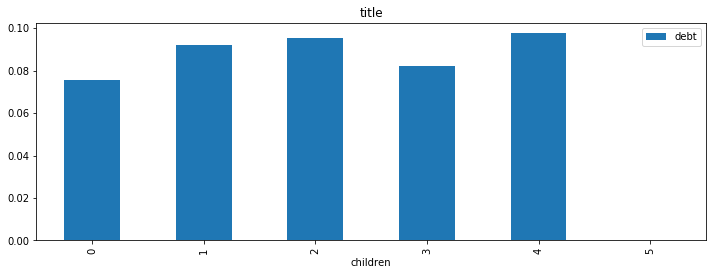

In [239]:
data.groupby('children').agg({'debt': 'mean'}).reset_index().plot(kind='bar', x='children', y='debt', title='title', figsize=(12,4))

**Вывод**

- По первой аггрегированной таблице мы получаем, что среднее количество детей среди тех, кто имел задолженность, выше
- по второму графику теория подтверждается: клиенты без детей реже допускают задолженности по крудиту. 
- у 5-ти детных совсем нет задолженностей. но в выборке их мало и они славо влияют на общую статистику

###  Есть ли зависимость между семейным положением и возвратом кредита в срок?

In [56]:
#Рассчитаем вероятность просрочки кредита в разрезе семейного положения:
pd.pivot_table(data, values=["debt"], columns=["family_status"], aggfunc='mean')

family_status,Не женат / не замужем,в разводе,вдовец / вдова,гражданский брак,женат / замужем
debt,0.097842,0.071247,0.065539,0.093119,0.075575


In [57]:
#Рассчитаем вероятность просрочки кредита в разрезе семейного положения и кол-ва детей:
pd.pivot_table(data, index=["children"], values=["debt"], columns=["family_status"], aggfunc='mean')

debt                                            \
family_status Не женат / не замужем в разводе вдовец / вдова гражданский брак   
children                                                                        
0                          0.093375  0.070785       0.061758         0.083548   
1                          0.114094  0.067524       0.090909         0.119312   
2                          0.121622  0.088608       0.150000         0.087977   
3                          0.125000  0.090909       0.000000         0.142857   
4                          0.500000  0.000000       0.000000         0.000000   
5                               NaN       NaN            NaN         0.000000   

                               
family_status женат / замужем  
children                       
0                    0.069114  
1                    0.082210  
2                    0.095082  
3                    0.068826  
4                    0.103448  
5                    0.000000

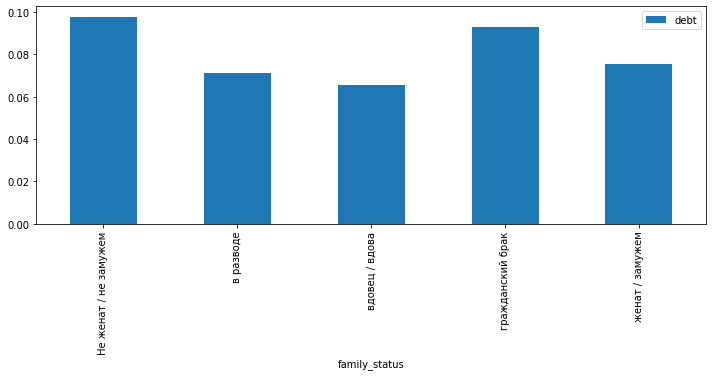

In [240]:
data.groupby('family_status').agg({'debt': 'mean'}).reset_index().plot(kind='bar', x='family_status', y='debt', title='', figsize=(12,4))

**Вывод**

 Видим, что семейное положение влияет на возврат кредита: не женатые и пары в гражданском браке допускают просрочки чаще

### Есть ли зависимость между уровнем дохода и возвратом кредита в срок?

In [241]:
data.groupby('debt').agg({'total_income': 'mean'})

,total_income
debt,
0,165889.196751
1,161177.529280


In [59]:
#Рассчитаем вероятность просрочки кредита в разрезе дохода:
pd.pivot_table(data, values=["debt"], columns=["total_income_group"], aggfunc='mean')

total_income_group,1. Менее 30000,2. 30000 - 50000,3. 50000 - 80000,4. 80000 - 120000,5. 120000 - 160000,6. 160000 - 200000,7. 200000 - 300000,8. 300000 - 500000,9. Более 500000
debt,0.090909,0.060519,0.080149,0.082285,0.090435,0.081998,0.070279,0.073777,0.063063


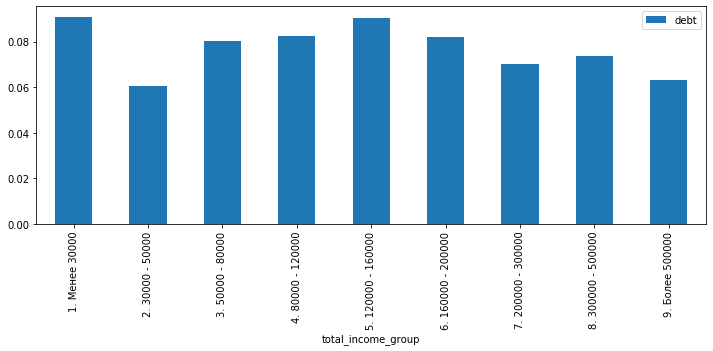

In [242]:
data.groupby('total_income_group').agg({'debt': 'mean'}).reset_index().plot(kind='bar', x='total_income_group', y='debt', title='', figsize=(12,4))

**Вывод**

 - Доход тех, кто позволяет себе просрочки по кредиту чуть ниже. Но разница не большая
 - По графику видим, что вероятность просрочки у людей и очень низким (до 30000) и средним (120000-160000) выше. Клиенты с очень высоким доходом (более 500000) позволяют себе просрочки заменто реже

### Как разные цели кредита влияют на его возврат в срок?

In [62]:
#Рассчитаем вероятность просрочки кредита в целей кредита:
pd.pivot_table(data, values=["debt"], index=["purpose_group"], aggfunc='mean').reset_index()

,purpose_group,debt
0,1. покупка недвижимости / жилья,0.069968
1,2. строительство недвижимости / жилья,0.076799
2,3. автомобиль,0.093236
3,4. образование,0.092947
4,5. ремонт,0.058140
5,6. свадьба,0.078730
6,7. операция,0.079193
7,8. жилье (без уточнения),0.072441
8,9. недвижимость (без уточнения),0.065391


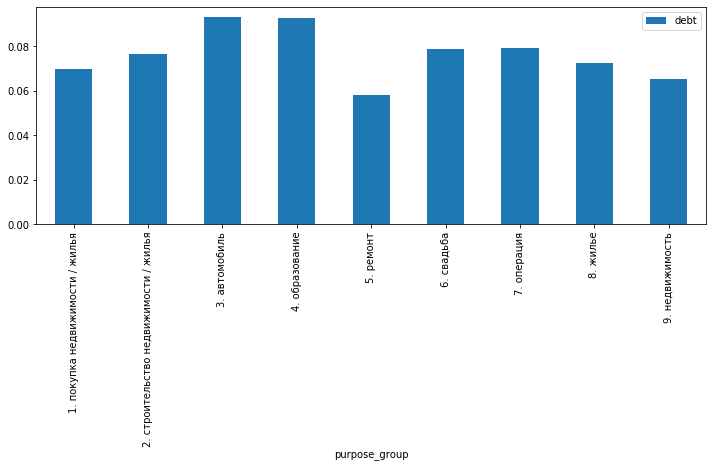

In [243]:
data.groupby('purpose_group').agg({'debt': 'mean'}).reset_index().plot(kind='bar', x='purpose_group', y='debt', title='', figsize=(12,4))

**Вывод**

 - если одним прекрасным утром человек решил смнить жизнь: купил беху в кредит и в кредит взял курс на Практикуме - это рисковый парень во всех смыслах

## Общий вывод

1. Проанализировали данные, выявив:
  - не валидные значения в некоторых столбцах (children, days_employed)
  - пропуски (в столбцах days_employed, total_income)
  - дубликаты как в одлельных переменных, так и целые строчки
  
2. Почистили данные, удалили выбросы
3. Исследовали васивимость отдачи кредита от ряда переменных, попутно проведя категоризацию переменных


4. В результате анализа сделали выводы:
   - клиенты без детей в среднем отдают кредиты лучше
   - не женатые и пары в гражданском браке под повышенным риском не отдачи кредита
   - доход имеет значение, то не такое сильное, как стоило ожидать
   - студенты Практикум и не тольно на авто в кредит тоже в зоне риска )) А вот деньги, взятые на ремонт и покупку жилья, отдают хорошо
   